In [1]:
from pendsim import sim, controller, viz
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# Swing Up of Pendulum From Resting Position With Energy Control

It's quite alright if the pendulum starts from an upright position. We can stabilize it with simple controllers, even as simple as Bang-Bang (On-Off) control. But what about when it is in the downward position? We will need a controller that can guide the pendulum from the lower position, completely through the non-linear region (near $\theta=\pm \pi/2$), and to the upward position.

Any simple (linear) controller will fail to guide us through this non-linear region. So what do we do? Fortunately, we have an option: swing up by energy control.

The swing-up strategy exploits that the potential energy of the system is a good proxy of the state. Namely, that the maximum energy point is also the desired point for the controller: at $\theta=0$, the small mass $m$ is as high as it could possibly be. At $\theta=\pi$, the energy is at a minimum. And the position of the large mass has no effect on the potential energy of the system, because the cart is always on level ground. A successful swing-up strategy will pump energy into the system to maximize the potential energy.

Functions which map the system state to a scalar, and which serve as a good proxy for the success or failure of a the state, are Lyapunov functions. A increase (or decrease) in a Lyapunov function must always result in driving the system towards a goal state. With these properties, so long as the Lyapunov function increases (or decreases), the state will be driven towards the goal. A control strategy can then be derived from the derivative of the Lyapunov function, with the control input driving the Lyapunov function in the desired direction.

Often, the energy of the system under control is a good starting point for deriving a Lyapunov function.

In this case, we use the following as the Lyapunov function:

$$
V = \frac{(E-E_0)^2}{2} 
$$

Rearranging potential energy terms and differentiating yields the control strategy:

$$ 
u = k (E - E_0) \dot{\theta} \cos{\theta}
$$

Which we can see is a function of the energy loss, the angular velocity, and the pendulum position. In particular, when $\theta=\pi/2$ or $\theta=-\pi/2$, no amount of sideways push will change the pendulum angle. When $\theta=\pi$ or $\theta=0$, a sideways push affects the pendulum angle the most. This behavior is captured by the $\cos{\theta}$ term. This term is then scaled by $\dot{\theta}$; when $\dot{\theta}$ is positive, the control action pushes left; when $\dot{\theta}$ is negative, the control action pushes right. Finally, the amount of push is scaled by the energy of the system; when $E=E_0$, the action is 0. 

The derivation of this strategy and particular details can be found in Astrom's [Swinging up a Pendulum by Energy Control](https://www.sciencedirect.com/science/article/pii/S0005109899001405). 

For the actual strategy, rather than using an arbitrary gain $k$, we use a coefficient $n$ times the gravity $g$ as the gain. 

$u = n g \hspace{0.25em} \text{sign}(\hspace{0.25em}  (E - E_0) \dot{\theta} \cos{\theta} \hspace{0.25em} )$

In [2]:
force_fn = lambda t: 0
dt = 0.01
t_final = 20

In [3]:
pend = sim.Pendulum(
    2.0,
    1.0,
    1.0,
    initial_state = np.array([0.0, 0.0, -np.pi, 0.0])
)

In [4]:
# function to take the sign of `x` argument
def sign(x):
    if x >= 0:
        return 1
    else:
        return -1
# function to wrap pi
def wrappi(theta):
    return (theta + np.pi) % (2 * np.pi) - np.pi

In [5]:
class SwingUp(controller.Controller):
    def __init__(self, k, pend):
        self.k = k
        # gravity constant of the pendulum
        self.pend = pend
        # prev error for PID control
        self.prev_err, self.integrator = 0, 0
    def policy(self, state, dt):
        # unpack state
        _, _, theta, thetadot = state
        # potential energy
        E = - self.pend.m*self.pend.g*self.pend.l*np.cos(theta)
        # potential energy zero-point
        E0 = 0
        # swing up action
        swingup = self.k * self.pend.g * sign((E - E0) * thetadot * np.cos(theta))
        # pid action
        pid = self.do_pid(dt, 50, 0, 2, state)
        # weight over pid/swingup
        wt_c = 0.25
        wt = np.exp(-theta**2/wt_c)
        # if near theta, wt -> 1 and (1-wt) -> 0
        action = wt * pid + (1-wt) * swingup
        return action, {}

Let's have a look at what's going on here. First, we take $\theta$ and $\dot{\theta}$ out of the state. This control policy doesn't rely on $x$ and $\dot{x}$.

Then, we calculate the potential energy of the pendulum position: $E = - m g l \cos{\theta}$. The maximum potential energy with that calculation can be had when $E=0$.

This is a hybrid policy, where we either want to take action from a PD (*) control strategy (if the pendulum is up in the air) or from a swing-up strategy (if it is hanging). So we calculate both.

Finally, we will multiply these two strategies by a weighted average.

(*) PD, and not PID, because integral gain is set to zero -- to see why that results in good control for this system, have a look at the "PD" notebook!

The weighted average is shown below.

We can see that in the area near $\pi=0$, the controller chooses mostly a PD strategy, while anywhere far away from there, it chooses a swing-up strategy; it switches rapidly, but smoothly, in the area near $\pi=0$ from one to the other.

We need to be careful with such hybrid control strategies; they can have mysterious results in the boundary region. But this one seems to work OK, and besides, this is a simulation!

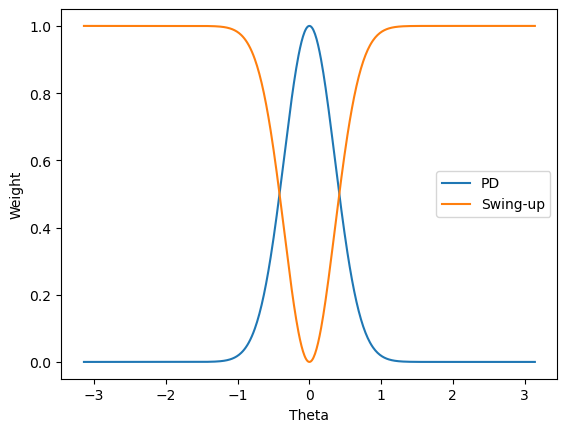

In [6]:
x = np.linspace(-np.pi, np.pi, 600)
y1 = np.exp(-x**2/0.25)
y2 = 1-np.exp(-x**2/0.25)
fig, ax = plt.subplots()
for y, label in zip((y1, y2), ("PD", "Swing-up")):
    ax.plot(x, y, label=label)
ax.legend()
ax.set_ylabel("Weight")
ax.set_xlabel("Theta")
plt.show()

Make the controller and run the simulation.

In [7]:
cont = SwingUp(0.5, pend)

In [8]:
simu = sim.Simulation(dt, t_final, force_fn)

res = simu.simulate(pend, cont)

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 5545.50it/s]


Now, a plot of $\theta$ over time.

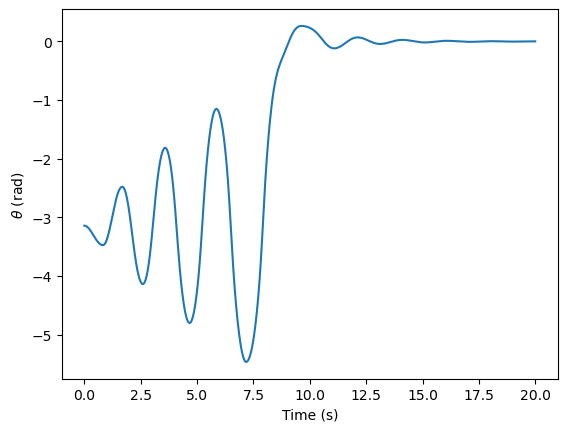

In [9]:
plt.plot(res[("state", "t")])
plt.ylabel(r"$\theta$ (rad)")
plt.xlabel("Time (s)")
plt.show()

We can see the controller working as intended. We know that energy is a function of $\theta$ only, so this chart shows that the energy is steadily pumped into the system. Finally, when $\theta$ reaches the zero point, the PD controller smoothly takes over, and removes the remaining perturbance.

This plot shows the control action over time. The swing-up strategy manifests as a square wave: that's the `sign` function. What we are doing here is adding energy to the pendulum as quickly as we possibly can. Either we're pushing as hard as we can left, or as hard as we can right. Because the potential energy is a scalar, pushing in either direction is adding energy, so long as we do it at the right time. Then, we can see the transition region, which has an interesting and turbulent control signal. Finally, the action of the PD controller takes over, with the little bit of derivative gain damping out the oscillations in the system.

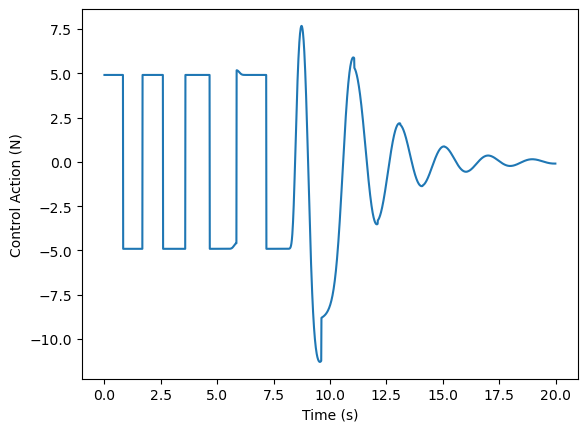

In [10]:
plt.plot(res[("control action", "control action")])
plt.ylabel("Control Action (N)")
plt.xlabel("Time (s)")
plt.show()

To see the relationship between energy and control action more clearly, we superimpose both onto the same plot:

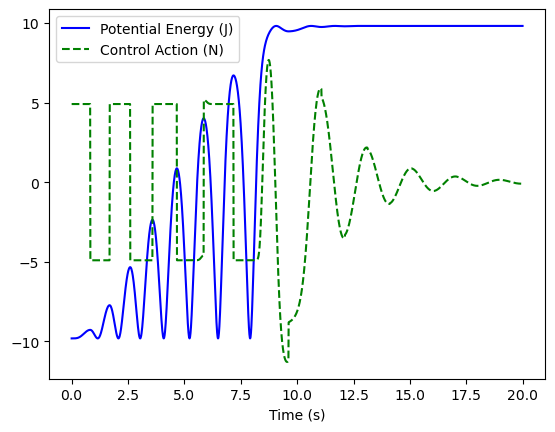

In [11]:
plt.plot(res[("energy", "potential")], "b", label="Potential Energy (J)")
plt.plot(res[("control action", "control action")], "g--", label="Control Action (N)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

And this is the controller we have designed: one which adds energy as quickly as possible, bringing the pendulum to a higher energy state, which we then stabilize using a different PD control strategy.

And finally, the animation of our strategy:

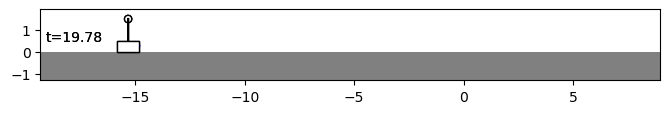

In [12]:
anim = viz.Visualizer(res, pend, dt)
ani = anim.animate()
HTML(ani.to_html5_video())